# SETUP

Import basic packages needed for this study.

In [60]:
import numpy as np
import os
import shutil
import time
import pandas as pd
from collections import OrderedDict

Import function from scikit-learn.

In [61]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Import tensorflow and keras.

In [62]:
import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers

Set randome seed in tensorflow to reproduce the results with tensorflow.keras. Codes are adopated from Brownlee (2017) https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

In [63]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Plotting setup.

In [64]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [65]:
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

Make the output stable across runs.

In [66]:
Random_Seed = 42

def reset_graph(seed=Random_Seed):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Dogs vs. Cats DATASET

Load in .npy files. The following codes are adopted from Miller (2018) run-cats-dogs-jump-start-dnn-v002.py.

In [67]:
dogs_1000_64_64_3 = np.load('dogs_1000_64_64_3.npy')
cats_1000_64_64_3 = np.load('cats_1000_64_64_3.npy')

Split the dataset into three subset: 600 samples of each class as train set, 200 samples of each as validation set, and 200 samples of each as test set. 

In [68]:
X_train_dogs = dogs_1000_64_64_3[:600]
X_train_cats = cats_1000_64_64_3[:600]
X_val_dogs = dogs_1000_64_64_3[600:800]
X_val_cats = cats_1000_64_64_3[600:800]
X_test_dogs = dogs_1000_64_64_3[800:]
X_test_cats = cats_1000_64_64_3[800:]

In [69]:
X_train = np.concatenate((X_train_dogs, X_train_cats), axis = 0) 
X_val = np.concatenate((X_val_dogs, X_val_cats), axis = 0) 
X_test = np.concatenate((X_test_dogs, X_test_cats), axis = 0) 

Define the labels to be used for each subset: dogs = 1, cats = 0 

In [70]:
y_train= np.concatenate((np.ones((600), dtype = np.int32), 
                      np.zeros((600), dtype = np.int32)), axis = 0)
y_val = np.concatenate((np.ones((200), dtype = np.int32), 
                      np.zeros((200), dtype = np.int32)), axis = 0)
y_test = np.concatenate((np.ones((200), dtype = np.int32), 
                      np.zeros((200), dtype = np.int32)), axis = 0)

In [71]:
len(X_train)

1200

In [72]:
len(X_train[0])

64

In [73]:
len(X_train[0][0])

64

In [74]:
len(X_train[0][0][0])

3

# Data Preprocessing

Currently, the each input data is in 64x64x3 (width, height, deepth) with pixel value ranges between 0 to 255. We want to rescale the pixel values to the [0, 1] interval before feed the input data in our neural networks.

In [75]:
X_train_scaled = X_train.astype('float32')/255.0
X_val_scaled = X_val.astype('float32')/255.0
X_test_scaled = X_test.astype('float32')/255.0

In [76]:
X_train_full_scaled = np.concatenate((X_train_scaled, X_val_scaled), axis = 0) 
y_train_full = np.concatenate((y_train, y_val), axis = 0)

Plot the first 15 images and labels.

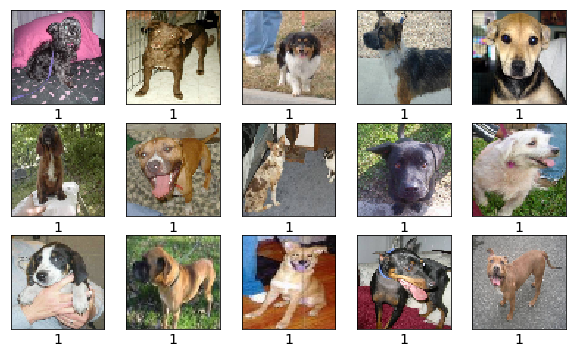

In [77]:
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_scaled[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

**Since we have a relatively small train set (1200 samples), the chance of overfitting is high. It's decided to introduce augmentation to mitigate this issue. The following codes are adopted from François Chollet (2018) 'Deep Learning with Python' Chapter 5 p135.**

# DENSE NEURAL NETWORK 

In this section, we focus on building and tuning a dense neural network. There are three (3) paramters under consideration: (1) number of hidden layers: 3 or 4 layers; (2) number of nodes in each hidden layer: 64 or 128; (3) optimizer: SGD or adam. This makes this experiment a 3x2 (3 factors of 2 levels) factorial design experiment. 

All the other parameters are set as constant at select values or default values. For each combination, we will run 20 epochs with a batch size of 128. Train accuracy and validation accuracy were recorded for each combination for comparison analysis.

Codes adoppted from Chollet (2017) "Train your first neural network: basic classification" at https://www.tensorflow.org/tutorials/keras/basic_classification and Miller (2017) 6_mnist_from_scratch_scikit-learn-ann-v001.

**Dense Neural Network with 3 Hidden Layer**

Define the function to build a dense neural network with 3 hidden layer, with activation function of hidden layer set to be ReLu, activation function of output layer to be sigmoid, loss function to be 'binary_crossentropy', and performanc index to be prediction accuracy. 

In [19]:
def dense_model_1(node, optimizer):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(64, 64, 3)))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Define the name of each combination test in this sub-experiment.

In [23]:
names_1 = ['3-hidden-64-nodes-with-SGD',
         '3-hidden-64-nodes-with-adam',
         '3-hidden-128-nodes-with-SGD',
         '3-hidden-128-nodes-with-adam']

Specify the values for the two experimental factors for this section. 

In [21]:
nodes = [64, 64, 128, 128]
optimizers = ['SGD', 'adam', 'SGD', 'adam']

Setup empty array to store the test results later.

In [22]:
index_for_method = 0 
dense_training_accuracy = []
dense_validation_accuracy = []
dense_training_loss = []
dense_validation_loss = []

Build and evaluate the four (4) combinations with training epochs = 20 and batch_size = 128.

In [23]:
for name, node, optimizer in zip(names_1, nodes, optimizers):
    print('\n------------------------------------')
    print('\nProcessing Training Method:', name)
    model = dense_model_1(node, optimizer)
    history = model.fit(X_train_scaled, 
              y_train, 
              epochs=20,
             batch_size = 128,
             validation_data=(X_val_scaled, y_val))
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    dense_training_accuracy.append(train_acc)
    dense_validation_accuracy.append(val_acc)
    dense_training_loss.append(train_loss)
    dense_validation_loss.append(val_loss)
                
    index_for_method += 1


------------------------------------

Processing Training Method: 3-hidden-64-nodes-with-SGD
Train on 1200 samples, validate on 400 samples
Epoch 1/20
1200/1200 [==============================] - 0s 391us/step - loss: 0.6956 - acc: 0.5308 - val_loss: 0.6844 - val_acc: 0.5700
Epoch 2/20
1200/1200 [==============================] - 0s 242us/step - loss: 0.6800 - acc: 0.5917 - val_loss: 0.6759 - val_acc: 0.5800
Epoch 3/20
1200/1200 [==============================] - 0s 244us/step - loss: 0.6658 - acc: 0.6233 - val_loss: 0.6718 - val_acc: 0.5525
Epoch 4/20
1200/1200 [==============================] - 0s 219us/step - loss: 0.6553 - acc: 0.6342 - val_loss: 0.6431 - val_acc: 0.7150
Epoch 5/20
1200/1200 [==============================] - 0s 204us/step - loss: 0.6645 - acc: 0.6258 - val_loss: 0.6527 - val_acc: 0.6425
Epoch 6/20
1200/1200 [==============================] - 0s 238us/step - loss: 0.6329 - acc: 0.6950 - val_loss: 0.6731 - val_acc: 0.5550
Epoch 7/20
1200/1200 [=====================

Epoch 18/20
1200/1200 [==============================] - 0s 311us/step - loss: 0.5589 - acc: 0.7225 - val_loss: 0.7041 - val_acc: 0.5725
Epoch 19/20
1200/1200 [==============================] - 0s 389us/step - loss: 0.5375 - acc: 0.7508 - val_loss: 0.5525 - val_acc: 0.7275
Epoch 20/20
1200/1200 [==============================] - 0s 338us/step - loss: 0.5182 - acc: 0.7533 - val_loss: 0.5544 - val_acc: 0.7325

------------------------------------

Processing Training Method: 3-hidden-128-nodes-with-adam
Train on 1200 samples, validate on 400 samples
Epoch 1/20
1200/1200 [==============================] - 1s 888us/step - loss: 1.0058 - acc: 0.4892 - val_loss: 0.7935 - val_acc: 0.5000
Epoch 2/20
1200/1200 [==============================] - 1s 503us/step - loss: 0.7951 - acc: 0.5050 - val_loss: 0.6704 - val_acc: 0.5650
Epoch 3/20
1200/1200 [==============================] - 1s 527us/step - loss: 0.7040 - acc: 0.5592 - val_loss: 0.7409 - val_acc: 0.5125
Epoch 4/20
1200/1200 [================

Plotting training and validation accuracy for each combination.

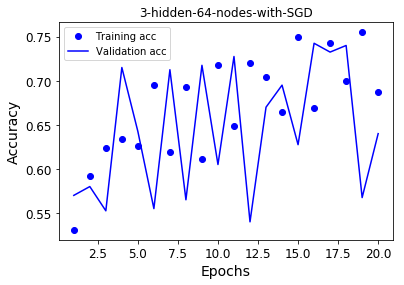

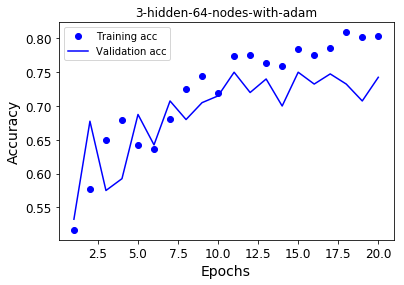

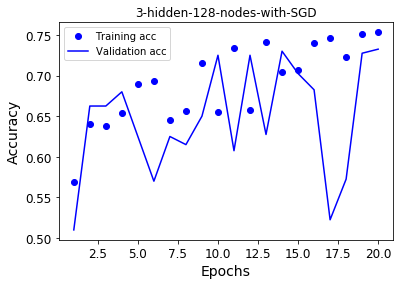

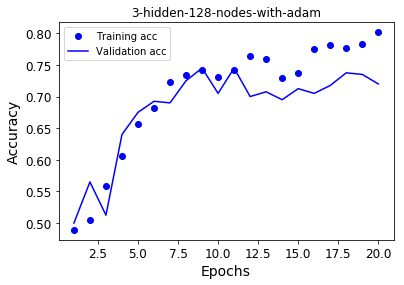

In [24]:
epochs = range(1, 21)

for i in range(4):
    plt.plot(epochs, dense_training_accuracy[i], 'bo', label='Training acc')
    plt.plot(epochs, dense_validation_accuracy[i], 'b', label='Validation acc')
    plt.title(names_1[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Plotting training and validation loss for each combination.

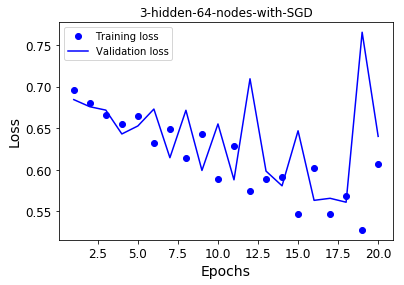

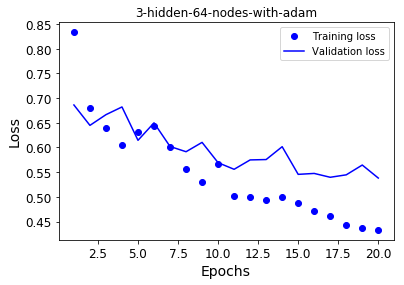

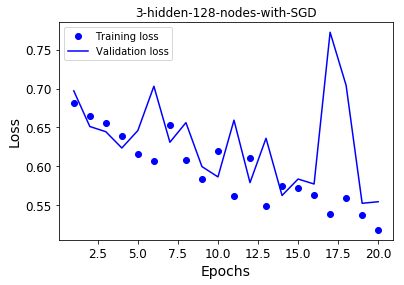

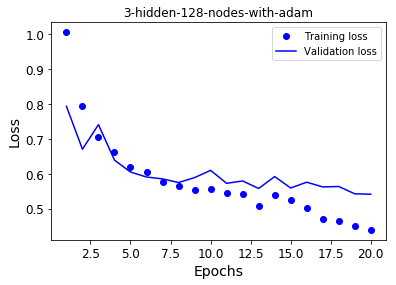

In [25]:
epochs = range(1, 21)

for i in range(4):
    plt.plot(epochs, dense_training_loss[i], 'bo', label='Training loss')
    plt.plot(epochs, dense_validation_loss[i], 'b', label='Validation loss')
    plt.title(names_1[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

The results show that, when the other hyperparamter setttins are the same, optimizer adam outperformed optimizer SGD because (1) it produced higher predictive accuracy and lower loss on both train and validation set; (2) when using SGD, the model's performance on validation set was not consistent. While the general trend of SGD model performance goes up, its performance on validation set gose up and down. This is evidence of poor generalization. Therefore, optimizer adam offer more reliable results than SGD in this case. 

Also, as the number of nodes increase from 64 to 128 on each hidden layer, the model performed better on train set but showed sign of overfitting at earlier training stage. This is expected. Because while more nodes increase the information receptive field, allowing the network to learn more features of the input data, it also could lead the network simply memorizing every details, including noise in the train set. This usually leads to overfitting. 

**Dense Neural Network with 4 Hidden Layer**

Define the function to build a dense neural network with 4 hidden layer (same number of hidden nodes on each layer), with activation function of hidden layer set to be ReLu, activation function of output layer to be sigmoid, loss function to be 'binary_crossentropy", and performanc index to be prediction accuracy. 

In [26]:
def dense_model_2(node, optimizer):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(64, 64, 3)))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Define the name of each combination test in this sub-experiment.

In [27]:
names_2 = ['4-hidden-64-nodes-with-SGD',
         '4-hidden-64-nodes-with-adam',
         '4-hidden-128-nodes-with-SGD',
         '4-hidden-128-nodes-with-adam']

In [28]:
dense_training_accuracy = dense_training_accuracy[:4]
dense_validation_accuracy = dense_validation_accuracy[:4]
dense_training_loss = dense_training_loss[:4]
dense_validation_loss = dense_validation_loss[:4]

In [28]:
len(dense_training_accuracy)

4

Build and evaluate the four (4) combinations with training epochs = 20 and batch_size = 128.

In [29]:
for name, node, optimizer in zip(names_2, nodes, optimizers):
    print('\n------------------------------------')
    print('\nProcessing Training Method:', name)
    model = dense_model_1(node, optimizer)
    history = model.fit(X_train_scaled, 
              y_train, 
              epochs=20,
             batch_size = 128,
             validation_data=(X_val_scaled, y_val))
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    dense_training_accuracy.append(train_acc)
    dense_validation_accuracy.append(val_acc)
    dense_training_loss.append(train_loss)
    dense_validation_loss.append(val_loss)
                
    index_for_method += 1


------------------------------------

Processing Training Method: 4-hidden-64-nodes-with-SGD
Train on 1200 samples, validate on 400 samples
Epoch 1/20
1200/1200 [==============================] - 1s 495us/step - loss: 0.6913 - acc: 0.5083 - val_loss: 0.6794 - val_acc: 0.5300
Epoch 2/20
1200/1200 [==============================] - 0s 234us/step - loss: 0.6642 - acc: 0.6125 - val_loss: 0.6725 - val_acc: 0.5675
Epoch 3/20
1200/1200 [==============================] - 0s 237us/step - loss: 0.6508 - acc: 0.6250 - val_loss: 0.6439 - val_acc: 0.6750
Epoch 4/20
1200/1200 [==============================] - 0s 241us/step - loss: 0.6420 - acc: 0.6425 - val_loss: 0.7508 - val_acc: 0.5025
Epoch 5/20
1200/1200 [==============================] - 0s 215us/step - loss: 0.6545 - acc: 0.6300 - val_loss: 0.6220 - val_acc: 0.6725
Epoch 6/20
1200/1200 [==============================] - 0s 234us/step - loss: 0.6079 - acc: 0.6833 - val_loss: 0.7252 - val_acc: 0.5200
Epoch 7/20
1200/1200 [=====================

Epoch 18/20
1200/1200 [==============================] - 0s 297us/step - loss: 0.5054 - acc: 0.7742 - val_loss: 0.5524 - val_acc: 0.7500
Epoch 19/20
1200/1200 [==============================] - 0s 280us/step - loss: 0.5370 - acc: 0.7425 - val_loss: 0.5832 - val_acc: 0.6925
Epoch 20/20
1200/1200 [==============================] - 0s 290us/step - loss: 0.5479 - acc: 0.7333 - val_loss: 0.5788 - val_acc: 0.7175

------------------------------------

Processing Training Method: 4-hidden-128-nodes-with-adam
Train on 1200 samples, validate on 400 samples
Epoch 1/20
1200/1200 [==============================] - 1s 923us/step - loss: 0.9125 - acc: 0.5175 - val_loss: 0.7145 - val_acc: 0.5000
Epoch 2/20
1200/1200 [==============================] - 1s 518us/step - loss: 0.6824 - acc: 0.5633 - val_loss: 0.6701 - val_acc: 0.5325
Epoch 3/20
1200/1200 [==============================] - 1s 505us/step - loss: 0.6625 - acc: 0.5917 - val_loss: 0.6095 - val_acc: 0.7050
Epoch 4/20
1200/1200 [================

Plotting training and validation accuracy for each combination.

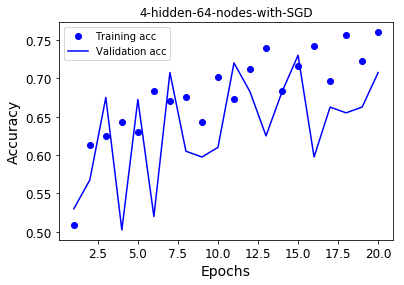

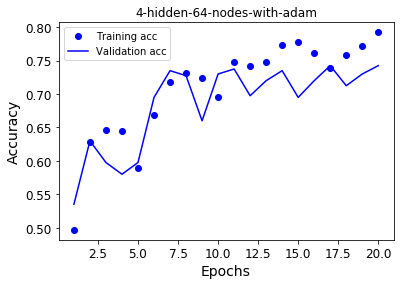

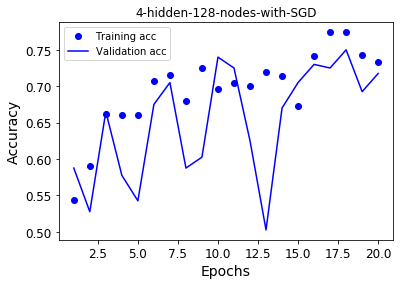

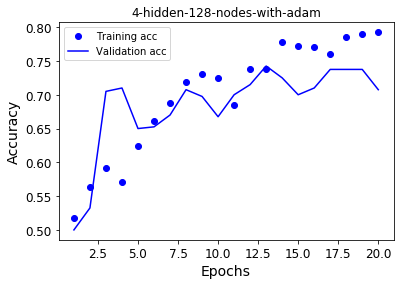

In [30]:
epochs = range(1, 21)

for i in range(4, 8):
    plt.plot(epochs, dense_training_accuracy[i], 'bo', label='Training acc')
    plt.plot(epochs, dense_validation_accuracy[i], 'b', label='Validation acc')
    plt.title(names_2[i-4])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Plotting training and validation loss for each combination.

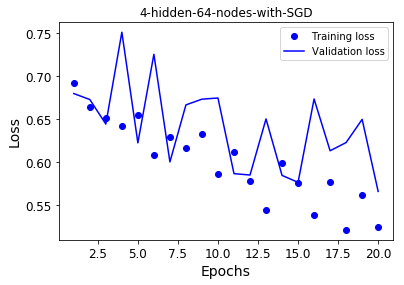

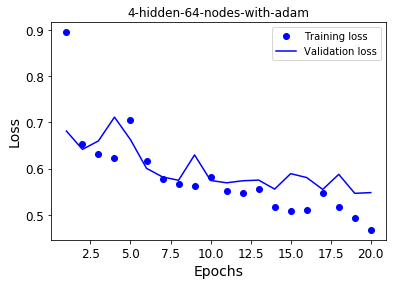

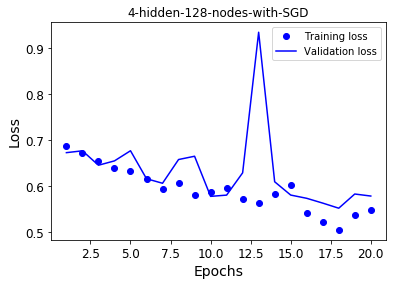

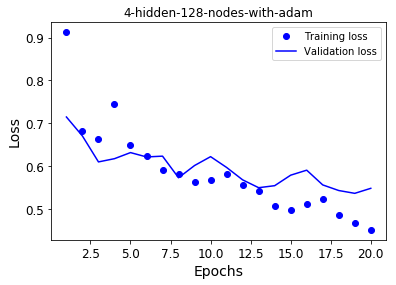

In [31]:
epochs = range(1, 21)

for i in range(4, 8):
    plt.plot(epochs, dense_training_loss[i], 'bo', label='Training loss')
    plt.plot(epochs, dense_validation_loss[i], 'b', label='Validation loss')
    plt.title(names_2[i-4])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Similar conclusions can be drawn from the above plots regarding the impact of optimzier adam / SGD and number of hidden nodes.

Compare the results from all eight (2) models to exame the impact of number of hidden layers

In [32]:
from collections import OrderedDict

In [33]:
dense_training_accuracy_final = []
dense_validation_accuracy_final = []
dense_training_loss_final = []
dense_validation_loss_final = []

for i in range(8):
    dense_training_accuracy_final.append(dense_training_accuracy[i][19])
    dense_validation_accuracy_final.append(dense_validation_accuracy[i][19])
    dense_training_loss_final.append(dense_training_loss[i][19])
    dense_validation_loss_final.append(dense_validation_loss[i][19])

In [34]:
names = names_1 + names_2
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Train Set Accuracy', dense_training_accuracy_final),
                        ('Val Set Accuracy', dense_validation_accuracy_final),
                        ('Train Set Loss',dense_training_loss_final),
                        ('Val Set Loss', dense_validation_loss_final)]))
print(results)

                    Method Name  Train Set Accuracy  Val Set Accuracy  \
0    3-hidden-64-nodes-with-SGD            0.687500            0.6400   
1   3-hidden-64-nodes-with-adam            0.804167            0.7425   
2   3-hidden-128-nodes-with-SGD            0.753333            0.7325   
3  3-hidden-128-nodes-with-adam            0.801667            0.7200   
4    4-hidden-64-nodes-with-SGD            0.760000            0.7075   
5   4-hidden-64-nodes-with-adam            0.792500            0.7425   
6   4-hidden-128-nodes-with-SGD            0.733333            0.7175   
7  4-hidden-128-nodes-with-adam            0.792500            0.7075   

   Train Set Loss  Val Set Loss  
0        0.606881      0.640221  
1        0.433000      0.538045  
2        0.518235      0.554447  
3        0.438918      0.541319  
4        0.523618      0.565447  
5        0.467202      0.547978  
6        0.547917      0.578795  
7        0.450606      0.547808  


The above results show that simply adding another hidden layer doesn't always gaurantee improved performance.

When we compare the nuemeric results, model 3-hidden-64-nodes-with-adam seem to perform best among all for our dataset. However, it is clear that we may have concern about overfitting as the preditive accuracy on train is higher than it on val set, and the train loss is lower than val loss. Therefore, it's decided to utilize dropout and reduce the training epochs to 10 to retrain the model on the entire train set. 

In [19]:
from keras import regularizers

def dense_model(node, optimizer):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(64, 64, 3)))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu'))
    model.add(layers.Dense(node, activation='relu')) 
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [20]:
start_time = time.clock()
DNN = dense_model(64, 'adam')
history = DNN.fit(X_train_full_scaled, 
              y_train_full, 
              epochs=10,
             batch_size = 128)
dnn_train_acc = history.history['acc']
dnn_train_loss = history.history['loss']
dnn_test_loss, dnn_test_acc = DNN.evaluate(X_test_scaled, y_test)
end_time = time.clock()
dnn_run = end_time - start_time

Epoch 1/10
1600/1600 [==============================] - 1s 526us/step - loss: 0.9511 - acc: 0.5256
Epoch 2/10
1600/1600 [==============================] - 0s 260us/step - loss: 0.6930 - acc: 0.5837
Epoch 3/10
1600/1600 [==============================] - 0s 272us/step - loss: 0.6438 - acc: 0.6313
Epoch 4/10
1600/1600 [==============================] - 0s 191us/step - loss: 0.6332 - acc: 0.6750
Epoch 5/10
1600/1600 [==============================] - 0s 266us/step - loss: 0.5956 - acc: 0.7119
Epoch 6/10
1600/1600 [==============================] - 0s 280us/step - loss: 0.5796 - acc: 0.7250 0s - loss: 0.5695 - acc: 0.72
Epoch 7/10
1600/1600 [==============================] - 0s 274us/step - loss: 0.5522 - acc: 0.7506
Epoch 8/10
1600/1600 [==============================] - 0s 240us/step - loss: 0.5483 - acc: 0.7606
Epoch 9/10
1600/1600 [==============================] - 0s 287us/step - loss: 0.5340 - acc: 0.7675
Epoch 10/10
400/400 [==============================] - 0s 304us/step


In [21]:
DNN.save('cats_and_dogs_small_dnn.h5')

In [24]:
print('\nProcessing Training Method:', names_1[1])
print('Train Accuracy after 10 epochs training:', dnn_train_acc[9])
print('Test Accuracy', dnn_test_acc)
print('Train Loss after 10 epochs training', dnn_train_loss[9])
print('Test Loss', dnn_test_loss)
print('Run Time', dnn_run)


Processing Training Method: 3-hidden-64-nodes-with-adam
Train Accuracy after 10 epochs training: 0.75875
Test Accuracy 0.715
Train Loss after 10 epochs training 0.5282622265815735
Test Loss 0.5853914964199066
Run Time 5.371927808018555


# CONVOLUTIONAL NEURAL NETWORK

In this section, we are concerned about building a convolutional neural network with a stack of alternated Conv2D (with relu activation) and MaxPooling2D layers to achieve high prediction accuracy. There are three (3) paramters under consideration: (1) number of alternated convolutional and pooling layers: 2 layer of alternated Conv2D and MaxPooling2D, 3 layers of calternated Conv2D and MaxPooling2D; (2) filter size: 32, 64 (3) kernal size of convolutional layer: 3x3, 5x5.

All the other parameters are set as constant at select values or default values. For each combination, we will run 10 epochs with a batch size of 128. accuracy and validation accuracy were recorded for each combination for comparison analysis.

**CNN with 2 layer of alternated Conv2D and MaxPooling2D.**

Define the function to build a cnn with 1 layer of convolutional and pooling, with activation function of covnet set to be ReLu, strides of covnet to be default (1, 1), padding enabled. max_pooling with a pool_size of (2, 2) and strdies of (2, 2), a dense layer of 100 nodes paired with ReLu activation function, and an output layer of 1 node paired sigmoid function. The loss function is 'binary_crossentropy", optimizer is 'adam', and performanc index is prediction accuracy. 

In [26]:
def CNN_model_1 (filters, kernel_size):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         padding='same', 
                                         activation='relu', 
                                         input_shape=(64, 64, 3))) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         padding='same', 
                                         activation='relu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    return model

Define the name of each of the test in this sub-experiments.

In [27]:
names_1 = ['2-covpool-32-filters-3x3',
         '2-covpool-32-filters-5x5',
         '2-covpool-64-filters-3x3',
         '2-covpool-64-filters-5x5']

Specify the value of the two experiment factors. 

In [28]:
filters_cnn = [32, 32, 64, 64]
kernel_sizes = [3, 5, 3, 5]

Setup empty arrays to store test results.

In [29]:
index_for_method = 0 
cnn_training_accuracy = []
cnn_validation_accuracy = []
cnn_training_loss = []
cnn_validation_loss = []

Build models and evaluate the four (4) combinations with training epochs = 10 and bach_size = 128.

In [30]:
for name, filters, kernel_size in zip(names_1, filters_cnn, kernel_sizes):
    print('\n------------------------------------')
    print('\nProcessing Training Method:', name)
    model = CNN_model_1(filters, kernel_size)
    history = model.fit(X_train_scaled, 
              y_train, 
              epochs=10,
             batch_size = 128,
             validation_data=(X_val_scaled, y_val))
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    cnn_training_accuracy.append(train_acc)
    cnn_validation_accuracy.append(val_acc)
    cnn_training_loss.append(train_loss)
    cnn_validation_loss.append(val_loss)
                
    index_for_method += 1


------------------------------------

Processing Training Method: 2-covpool-32-filters-3x3
Train on 1200 samples, validate on 400 samples
Epoch 1/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.7622 - acc: 0.5083 - val_loss: 0.6809 - val_acc: 0.7225
Epoch 2/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.6642 - acc: 0.6850 - val_loss: 0.6373 - val_acc: 0.6175
Epoch 3/10
1200/1200 [==============================] - 7s 5ms/step - loss: 0.5836 - acc: 0.7158 - val_loss: 0.5294 - val_acc: 0.7750
Epoch 4/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.5092 - acc: 0.7717 - val_loss: 0.5868 - val_acc: 0.6450
Epoch 5/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.5385 - acc: 0.7242 - val_loss: 0.4825 - val_acc: 0.7750
Epoch 6/10
1200/1200 [==============================] - 6s 5ms/step - loss: 0.4831 - acc: 0.7892 - val_loss: 0.4639 - val_acc: 0.7975
Epoch 7/10
1200/1200 [==============================] - 7

Plot training and validation accuracy for each test combination. 

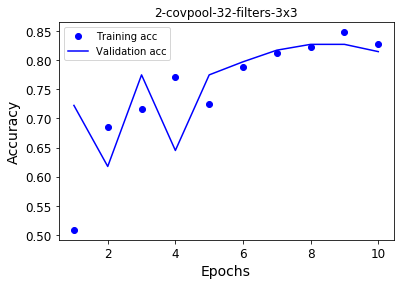

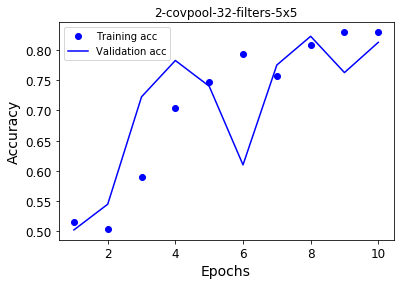

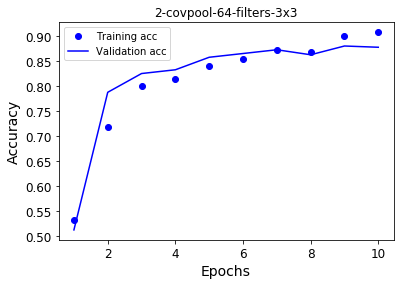

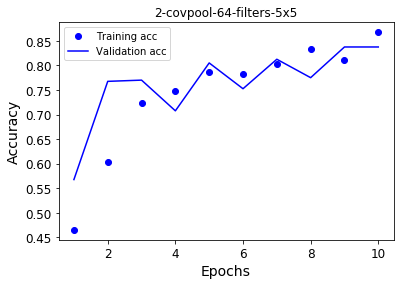

In [31]:
epochs = range(1, 11)

for i in range(4):
    plt.plot(epochs, cnn_training_accuracy[i], 'bo', label='Training acc')
    plt.plot(epochs, cnn_validation_accuracy[i], 'b', label='Validation acc')
    plt.title(names_1[i])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Plot training and validation loss for each test combination.

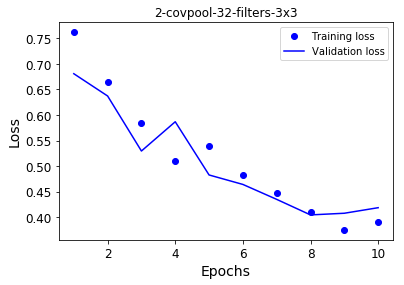

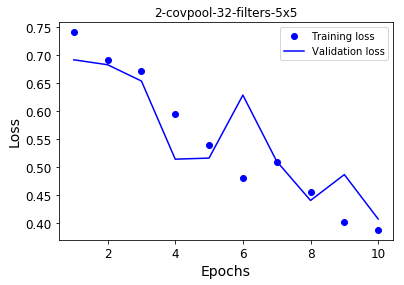

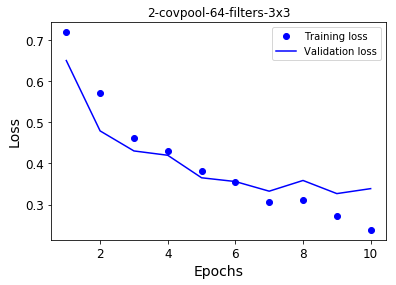

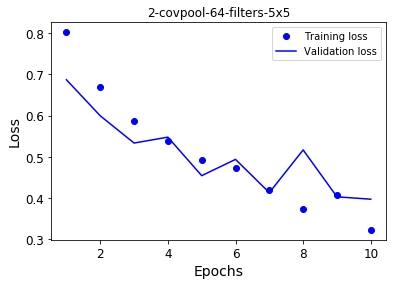

In [32]:
epochs = range(1, 11)

for i in range(4):
    plt.plot(epochs, cnn_training_loss[i], 'bo', label='Training loss')
    plt.plot(epochs, cnn_validation_loss[i], 'b', label='Validation loss')
    plt.title(names_1[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

The results show that smaller kernel size (3x3) provided better and more consistent performance than larger kernel size (5x5). Not only the predictive accuracy is higher on both train and val set, its performance on val set improves more consistently throughout the training. On the other hand, the performance model with kernel size of 5x5 on val set jumps up and down. This is expected as smaller kernel size means smaller filter mask, allowing the network to learn more minute details at various levels of abstractions. 

As the filters increase from 32 to 64, the model's predictive accuracy on train set and val set improved visibly. Larger filters means larger information receptive field, allowing the network to learn more features of the input data. 

At the same time, the models with smaller kernel size and larger filters do seem to be more prone to overfitting. This is understandable that as we allow the network to pick up more details, including noises, we also increase the risk that each layer of the cnn end up simply memorizing the corresponding output value instead of learning features that would generalize well.

**CNN with 3 layers of convolutional and pooling.**

Define the function to build a cnn with 3 layer of convolutional and pooling, with activation function of covnet set to be ReLu, strides of covnet to be (1, 1), max_pooling with a pool_size of (2, 2) and strdies of (2, 2), a dense layer of 100 nodes paired with ReLu activation function, and an output layer of 10 nodes paired softmax function. The loss function is 'sparse_categorical_crossentropy", optimizer is 'adam', and performanc index is prediction accuracy. 

In [33]:
def CNN_model_2 (filters, kernel_size):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         padding='same', 
                                         activation='relu', 
                                         input_shape=(64, 64, 3))) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         strides=(2, 2), padding='same', 
                                         activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         strides=(2, 2), padding='same', 
                                         activation='relu')) 
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    return model

Define the name of each of the test in this sub-experiments.

In [34]:
names_2 = ['3-covnet-32-filters-3x3',
         '3-covnet-32-filters-5x5',
         '3-covnet-64-filters-3x3',
         '3-covnet-64-filters-5x5']

Build models and evaluate the four (4) combinations with training epochs = 10 and bach_size = 512.

In [35]:
for name, filters, kernel_size in zip(names_2, filters_cnn, kernel_sizes):
    print('\n------------------------------------')
    print('\nProcessing Training Method:', name)
    model = CNN_model_2(filters, kernel_size)
    history = model.fit(X_train_scaled, 
              y_train, 
              epochs=10,
             batch_size = 128,
             validation_data=(X_val_scaled, y_val))
    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    cnn_training_accuracy.append(train_acc)
    cnn_validation_accuracy.append(val_acc)
    cnn_training_loss.append(train_loss)
    cnn_validation_loss.append(val_loss)
                
    index_for_method += 1


------------------------------------

Processing Training Method: 3-covnet-32-filters-3x3
Train on 1200 samples, validate on 400 samples
Epoch 1/10
1200/1200 [==============================] - 4s 4ms/step - loss: 1.6223 - acc: 0.3992 - val_loss: 0.7189 - val_acc: 0.5125
Epoch 2/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.6977 - acc: 0.5133 - val_loss: 0.7146 - val_acc: 0.5150
Epoch 3/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.6871 - acc: 0.5475 - val_loss: 0.7190 - val_acc: 0.5100
Epoch 4/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.6910 - acc: 0.5392 - val_loss: 0.6702 - val_acc: 0.5650
Epoch 5/10
1200/1200 [==============================] - 4s 3ms/step - loss: 0.6594 - acc: 0.5975 - val_loss: 0.6679 - val_acc: 0.5900
Epoch 6/10
1200/1200 [==============================] - 4s 4ms/step - loss: 0.6400 - acc: 0.6450 - val_loss: 0.6232 - val_acc: 0.6800
Epoch 7/10
1200/1200 [==============================] - 4s

Plot training and validation accuracy for each combination.

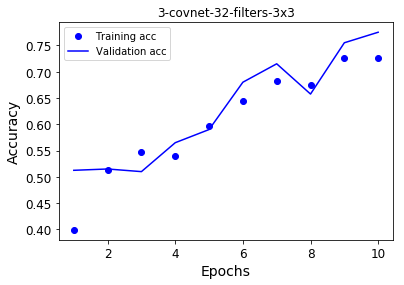

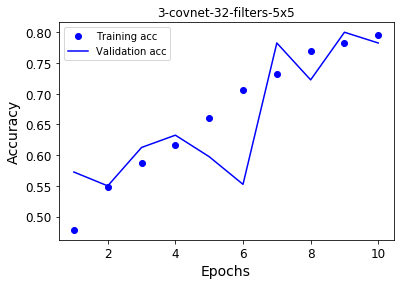

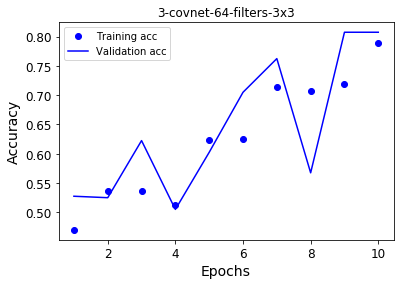

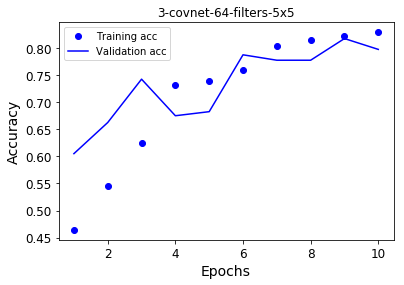

In [37]:
epochs = range(1, 11)

for i in range(4, 8):
    plt.plot(epochs, cnn_training_accuracy[i], 'bo', label='Training acc')
    plt.plot(epochs, cnn_validation_accuracy[i], 'b', label='Validation acc')
    plt.title(names_2[i-4])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Plot training and validation loss for each combiantion.

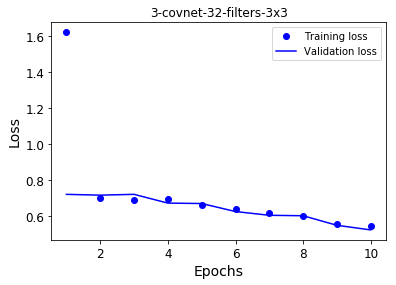

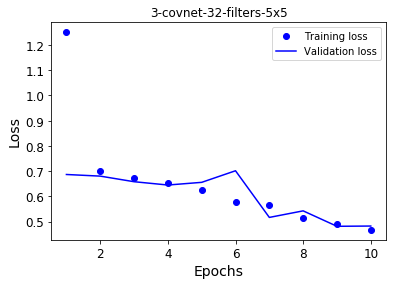

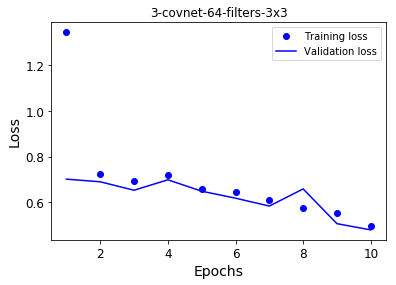

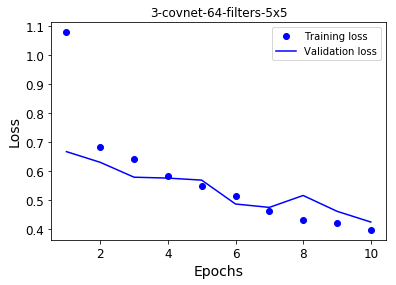

In [38]:
epochs = range(1, 11)

for i in range(4, 8):
    plt.plot(epochs, cnn_training_loss[i], 'bo', label='Training loss')
    plt.plot(epochs, cnn_validation_loss[i], 'b', label='Validation loss')
    plt.title(names_2[i-4])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Comapre the results of the two cnn architecture to see the impact of number of convolutional and pooling layers.

In [39]:
cnn_training_accuracy_final = []
cnn_validation_accuracy_final = []
cnn_training_loss_final = []
cnn_validation_loss_final = []

for i in range(8):
    cnn_training_accuracy_final.append(cnn_training_accuracy[i][5])
    cnn_validation_accuracy_final.append(cnn_validation_accuracy[i][5])
    cnn_training_loss_final.append(cnn_training_loss[i][5])
    cnn_validation_loss_final.append(cnn_validation_loss[i][5])

In [40]:
names = names_1 + names_2
results = pd.DataFrame(OrderedDict([('Method Name', names),
                        ('Train Set Accuracy', cnn_training_accuracy_final),
                        ('Val Set Accuracy', cnn_validation_accuracy_final),
                        ('Train Set Loss', cnn_training_loss_final),
                        ('Val Set Loss', cnn_validation_loss_final)]))
print(results)

                Method Name  Train Set Accuracy  Val Set Accuracy  \
0  2-covpool-32-filters-3x3            0.789167            0.7975   
1  2-covpool-32-filters-5x5            0.793333            0.6100   
2  2-covpool-64-filters-3x3            0.855000            0.8650   
3  2-covpool-64-filters-5x5            0.782500            0.7525   
4   3-covnet-32-filters-3x3            0.645000            0.6800   
5   3-covnet-32-filters-5x5            0.706667            0.5525   
6   3-covnet-64-filters-3x3            0.625000            0.7050   
7   3-covnet-64-filters-5x5            0.759167            0.7875   

   Train Set Loss  Val Set Loss  
0        0.483116      0.463917  
1        0.479881      0.628162  
2        0.355963      0.355960  
3        0.473502      0.493786  
4        0.639984      0.623198  
5        0.578576      0.701574  
6        0.646375      0.617698  
7        0.514529      0.487139  


Based on the results, model 2-covpool-64-filters-3x3 performed best for our dataset. Therefore, it is decided to train this model on the entire dataset and evaluate its performance on the test set. While the statistic above doesn't indicate overfitting, it's still decided to apply dropout to mitigate potential overfitting issue.

In [78]:
def CNN_model (filters, kernel_size):
    model = models.Sequential()
    model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         padding='same', 
                                         activation='relu', 
                                         input_shape=(64, 64, 3))) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Conv2D(filters=filters, kernel_size=kernel_size, 
                                         padding='same', 
                                         activation='relu')) 
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

    return model

In [79]:
start_time = time.clock()
CNN = CNN_model(64, 3)
history = CNN.fit(X_train_full_scaled, 
              y_train_full, 
              epochs=10,
             batch_size = 128)
cnn_train_acc = history.history['acc']
cnn_train_loss = history.history['loss']
cnn_test_loss, cnn_test_acc = CNN.evaluate(X_test_scaled, y_test)
end_time = time.clock()
cnn_run = end_time - start_time

Epoch 1/10
1600/1600 [==============================] - 15s 9ms/step - loss: 0.6895 - acc: 0.6050
Epoch 2/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.5365 - acc: 0.7694
Epoch 3/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.4581 - acc: 0.8113
Epoch 4/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.4022 - acc: 0.8287
Epoch 5/10
1600/1600 [==============================] - 17s 11ms/step - loss: 0.3623 - acc: 0.8569
Epoch 6/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.3721 - acc: 0.8381
Epoch 7/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.3191 - acc: 0.8663
Epoch 8/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.3103 - acc: 0.8719
Epoch 9/10
1600/1600 [==============================] - 16s 10ms/step - loss: 0.2631 - acc: 0.8931
Epoch 10/10
400/400 [==============================] - 2s 5ms/step


In [80]:
CNN.save('dogs_vs_cats_small_cnn.h5')

In [81]:
print('\nProcessing Training Method:', names_1[2])
print('Train Accuracy after 10 epochs training:', cnn_train_acc[9])
print('Test Accuracy', cnn_test_acc)
print('Train Loss after 10 epochs training', cnn_train_loss[9])
print('Test Loss', cnn_test_loss)
print('Run Time', cnn_run)


Processing Training Method: 2-covpool-64-filters-3x3
Train Accuracy after 10 epochs training: 0.89625
Test Accuracy 0.8525
Train Loss after 10 epochs training 0.24572092533111572
Test Loss 0.3243919512629509
Run Time 164.67043298430644


# COMPARISON ANALYSIS

In this section, we want to compare the performance of the two selected models in (1) prediction accuracy; (2) loss; (3) training time.

In [86]:
models = ['DNN', 'CNN']
train_accs = [dnn_train_acc[9], cnn_train_acc[9]]
train_losses = [dnn_train_loss[9], cnn_train_loss[9]]
test_accs = [dnn_test_acc, cnn_test_acc]
test_losses = [dnn_test_loss, cnn_test_loss]
run_time = [dnn_run, cnn_run]

In [87]:
compare = pd.DataFrame(OrderedDict([('Network', models),
                                    ('Train Accuracy', train_accs),
                                    ('Test Accuracy', test_accs),
                                    ('Train Loss', train_losses),
                                     ('Test Loss', test_losses),
                                     ('Run Time', run_time)]))
print(compare)

  Network  Train Accuracy  Test Accuracy  Train Loss  Test Loss    Run Time
0     DNN         0.75875         0.7150    0.528262   0.585391    5.371928
1     CNN         0.89625         0.8525    0.245721   0.324392  164.670433


As we can see, CNN indeed performed better than DNN. This is evident by its higher predictive accuracy on the test set as well as lower loss on the test set. However, it took much longer to train the CNN than DNN.

**Visualize CNN Intermediate Output**